In [51]:

import pickle
import pandas as pd
from tqdm import trange
import wandb
import argparse
import os
import requests
import argparse
# import shap
import requests

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from functools import reduce
from msd import get_tokenizer
from datasets import get_commit_from_repo
from transformers import pipeline

from models import *


In [52]:

with open(r"C:\secrets\github_token.txt", "r") as f:
    github_token = f.read()


def get_repository_language(repo_owner, repo_name):
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}"
    headers = {"Authorization": f"token {github_token}"}

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        repository = response.json()
        language = repository["language"]
        return language
    else:
        return None


def get_commit_message(repo_owner, repo_name, commit_sha):
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/commits/{commit_sha}"
    headers = {"Authorization": f"token {github_token}"}

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        commit_data = response.json()
        message = commit_data["commit"]["message"]
        return message
    else:
        return None


def wandb_to_df(wandb_json_table):
    df = pd.DataFrame(wandb_json_table.data, columns=[
                      "Name", "Hash", "Prediction", "Actual"])
    df.index = df["Hash"]
    df = df.drop(columns=["Hash"])
    return df


def merge_rows(df, args):
    def my_avg(x): return int(0.5+(sum(x)/len(x)))
    def my_any(x): return int(sum(x) > 0)
    def my_all(x): return int(sum(x) == len(x))
    aggr_dict = {"avg": my_avg, "any": my_any, "all": my_all}
    if args.aggr.lower() not in aggr_dict:
        raise ValueError("Aggregation function not found")

    df = df.groupby(["Hash", "Name"])
    if args.aggr.lower() == "any":
        df = df.any()
    elif args.aggr.lower() == "all":
        df = df.all()
    elif args.aggr.lower() == "avg":
        df = df.mean()
    else:
        raise ValueError("Aggregation function not found")
    df = df.reset_index()
    df.index = df["Hash"]
    return df


def get_best_accuracy(mall):
    best_accuracy = 0
    best_threshold = 0
    for i in range(100):
        final_accuracy = accuracy_score(
            mall['Actual'], mall['predicted_avg'] > i/100)
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_threshold = i/100

    return best_threshold, best_accuracy

def get_best_f1(mall):
    best_f1 = 0
    best_threshold = 0
    for i in range(100):
        final_f1 = f1_score(
            mall['Actual'], mall['predicted_avg'] > i/100)
        if final_f1 > best_f1:
            best_f1 = final_f1
            best_threshold = i/100

    return best_threshold, best_f1

repo_cache_dict = {}


def get_language_from_name(name):
    if name in repo_cache_dict:
        return repo_cache_dict[name]

    owner, repo = name.split("_", 1)
    lang = get_repository_language(owner, repo)
    repo_cache_dict[name] = lang
    return lang


def get_all_predictions(args, run):
    code_df = wandb_to_df(run.use_artifact(
        args.code_artifact).get(f"test_table_{args.fold}.table.json"))
    message_df = wandb_to_df(run.use_artifact(
        args.message_artifact).get(f"test_table_{args.fold}.table.json"))
    event_df = wandb_to_df(run.use_artifact(
        args.event_artifact).get(f"test_table_{args.fold}.table.json"))

    code_df = merge_rows(code_df, args)
    message_df = merge_rows(message_df, args)
    event_df = merge_rows(event_df, args)

    mall = pd.merge(pd.merge(code_df.add_suffix('_code'), message_df.add_suffix('_message'), left_index=True,
                             right_index=True), event_df.add_suffix('_time'), left_index=True, right_index=True)

    mall['predicted_avg'] = mall[['Prediction_code',
                                  'Prediction_message', 'Prediction_time']].mean(axis=1)
    return mall


def save_language_compare(mall, run):
    mall['language'] = mall.apply(
        lambda row: get_language_from_name(row['Name']), axis=1)
    langs = mall['language'].unique()
    langs = [lang for lang in langs if lang is not None]
    langs = sorted(langs)
    print(langs)
    return langs


def save_accuracy(args, mall, run):
    best_threshold, best_accuracy = get_best_accuracy(mall)

    print("Final accuracy: ", best_accuracy)
    print("Best threshold: ", best_threshold)
    run.summary["best_threshold"] = best_threshold
    run.summary["best_accuracy"] = best_accuracy

    if args.compare_languages:
        for language in mall['language'].unique():
            run.summary[f"best_threshold_{language}"], run.summary[f"best_accuracy_{language}"] = get_best_accuracy(
                mall[mall['language'] == language])
            print(f"Final accuracy for {language}: ",
                  run.summary[f"best_accuracy_{language}"])
            print(f"Best threshold for {language}: ",
                  run.summary[f"best_threshold_{language}"])
            
def make_url(row):
    owner, repo = row.get('Name_code').split("_", 1)
    commit_hash = row.get('Hash_code')
    return f"https://github.com/{owner}/{repo}/commit/{commit_hash}"


In [ ]:
mall[(mall['Prediction_time']>0.5) & (mall['Actual_time']==0.0)].apply(make_url, axis=1).to_list()

In [53]:
import argparse
args = argparse.Namespace()
args.code_artifact="nitzanfarhi/code4/run-ia1zinlc-test_table_0:v0"
args.message_artifact="nitzanfarhi/message4/run-q8hktc1v-test_table_0:v0"
args.event_artifact="nitzanfarhi/events4/run-agwcpmq1-test_table_0:v0"
args.message_model="nitzanfarhi/message4/Message_model_0.bin:v110"
args.aggr="avg"
args.local_dir=""
args.fold=0
args.compare_languages=True



In [54]:
os.environ["WANDB_NOTEBOOK_NAME"] = "results.ipynb"
run =  wandb.init(settings=wandb.Settings(start_method="thread"))

wandb: Currently logged in as: nitzan2611 (nitzanfarhi). Use `wandb login --relogin` to force relogin


In [55]:

mall = get_all_predictions(args, run)
if args.compare_languages:
    langs = save_language_compare(mall, run)
save_accuracy(args, mall, run)



wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


KeyError: 'Name'

In [25]:
from sklearn.metrics import accuracy_score

linux = mall[mall['Name']=='torvalds_linux']
accuracy_score(linux['Prediction'], linux['Actual'])

1.0

In [77]:
mall

,Hash_code,Name_code,Prediction_code,Actual_code,Hash_message,Name_message,Prediction_message,Actual_message,Hash_time,Name_time,Prediction_time,Actual_time,predicted_avg
Hash,,,,,,,,,,,,,
00c425ec77993773d823f018f64a5c44e17023ff,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,1.000000
019c345131b8e49e1336332997854ffc3105a4c4,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,0.000000
01a21de7441549d26ac0c0a9ff91385d16e5c21c,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,0.0,0.0,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,0.0,0.0,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,1.0,0.0,0.333333
01ef56cd5824ed6da1c11b37013a027fdef67524,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,1.0,1.0,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,1.0,1.0,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,0.0,1.0,0.666667
024c1f46dec6663e8238152b40d22cd945d7fc65,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,1.0,1.0,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,0.0,1.0,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,1.0,1.0,0.666667
ff5e37d3e1098a7ce2b9fe60389b14514932dd93,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,0.000000
ff7f6a20bda0334b7088da930e77e6b8e7114c27,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,0.000000


In [82]:
name_res = [] 
mall['Actual'] = mall['Actual_code']
for name in mall['Name_code'].unique()[:]:
    accuracy = get_best_accuracy(mall[mall['Name_code']==name])
    size = mall[mall['Name_code']==name].shape[0] / mall.shape[0]
    name_res.append([name, accuracy[1],size])
    
name_pd = pd.DataFrame(name_res, columns=["Name_code", "accuracy","share of all repos"])
name_pd = name_pd.sort_values(by="share of all repos", ascending=False)
run.log({"name_comparison": wandb.Table(dataframe=name_pd)})


,Name_code,accuracy,share of all repos
14,torvalds_linux,1.000000,0.126389
9,phpmyadmin_phpmyadmin,0.916667,0.033333
12,wordpress_wordpress,0.952381,0.029167
7,imagemagick_imagemagick,1.000000,0.025000
1,gpac_gpac,0.937500,0.022222
...,...,...,...
161,federatedai_fate,1.000000,0.001389
162,nielsbasjes_yauaa,1.000000,0.001389
163,glennrp_libpng,1.000000,0.001389
164,opennms_opennms,1.000000,0.001389


In [88]:
pd.set_option('display.max_rows', 300)
name_pd = name_pd.sort_values(by="accuracy", ascending=True)
name_pd.head(300)

,Name_code,accuracy,share of all repos
243,litespeedtech_lsquic,0.000000,0.001389
139,bluez_bluez,0.000000,0.001389
298,aurelia_path,0.000000,0.001389
166,knik0_faad2,0.000000,0.001389
270,ronf_asyncssh,0.000000,0.001389
68,simpleledger_slpjs,0.500000,0.002778
213,nilsteampassnet_teampass,0.500000,0.002778
265,arslancb_clipbucket,0.500000,0.002778
253,fasterxml_jackson-databind,0.500000,0.002778
62,gocd_gocd,0.500000,0.002778


In [19]:
run.save()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [6]:
lang_res = [] 
for language in mall['language'].unique()[:]:
    accuracy = get_best_accuracy(mall[mall['language']==language])
    size = mall[mall['language']==language].shape[0] / mall.shape[0]
    lang_res.append([language, accuracy,size])
    
lang_pd = pd.DataFrame(lang_res, columns=["language", "accuracy","share of all repos"])
run.log({"language_comparison": wandb.Table(dataframe=lang_pd)})

Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
inva

In [56]:
mall

,Hash_code,Name_code,Prediction_code,Actual_code,Hash_message,Name_message,Prediction_message,Actual_message,Hash_time,Name_time,Prediction_time,Actual_time,predicted_avg
Hash,,,,,,,,,,,,,
00c425ec77993773d823f018f64a5c44e17023ff,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,00c425ec77993773d823f018f64a5c44e17023ff,websockets_ws,1.0,1.0,1.000000
019c345131b8e49e1336332997854ffc3105a4c4,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,019c345131b8e49e1336332997854ffc3105a4c4,gpac_gpac,0.0,0.0,0.000000
01a21de7441549d26ac0c0a9ff91385d16e5c21c,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,0.0,0.0,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,0.0,0.0,01a21de7441549d26ac0c0a9ff91385d16e5c21c,juliangruber_brace-expansion,1.0,0.0,0.333333
01ef56cd5824ed6da1c11b37013a027fdef67524,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,1.0,1.0,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,1.0,1.0,01ef56cd5824ed6da1c11b37013a027fdef67524,sebhildebrandt_systeminformation,0.0,1.0,0.666667
024c1f46dec6663e8238152b40d22cd945d7fc65,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,024c1f46dec6663e8238152b40d22cd945d7fc65,horde_horde,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,1.0,1.0,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,0.0,1.0,ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab,pwndoc_pwndoc,1.0,1.0,0.666667
ff5e37d3e1098a7ce2b9fe60389b14514932dd93,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,ff5e37d3e1098a7ce2b9fe60389b14514932dd93,arslancb_clipbucket,0.0,1.0,0.000000
ff7f6a20bda0334b7088da930e77e6b8e7114c27,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,ff7f6a20bda0334b7088da930e77e6b8e7114c27,gnome_librsvg,0.0,0.0,0.000000


In [58]:
fps = mall[(mall['predicted_avg']>0.5) & (mall['Actual_message']==0.0)]

In [76]:
mall['predicted_avg']

Hash
00c425ec77993773d823f018f64a5c44e17023ff    1.000000
019c345131b8e49e1336332997854ffc3105a4c4    0.000000
01a21de7441549d26ac0c0a9ff91385d16e5c21c    0.333333
01ef56cd5824ed6da1c11b37013a027fdef67524    0.666667
024c1f46dec6663e8238152b40d22cd945d7fc65    0.000000
                                              ...   
ff1b868cec55f5b6c7a91e15a2b0b1f4324121ab    0.666667
ff5e37d3e1098a7ce2b9fe60389b14514932dd93    0.000000
ff7f6a20bda0334b7088da930e77e6b8e7114c27    0.000000
ffa720d90a79c1f33cf4c5a33403d09a67b42a66    0.666667
fff101b8f21dd9d027d7d6ce7114912337a1eb8c    0.333333
Name: predicted_avg, Length: 720, dtype: float64

In [8]:
# wandb.init()
args.message_model_type = "roberta"
args.message_model_name = "roberta-base"
args.multi_message_model_artifact = "nitzanfarhi/message4/Message_model_0.bin:v110"
args.message_tokenizer_name="roberta-base"
args.message_model_name="roberta-base"
args.model_cache_dir="cache_data/models"
args.dropout = 0.1
args.freeze_submodel_layers = True
args.do_lower_case = False
args.xshape1 = 20
args.xshape2 = 401
args.event_l1 = 883
args.event_l2 = 100
args.event_l3 = 114
args.event_activation = 'tanh'
args.events_model_type = 'conv1d'
args.cut_layers = False
args.event_window_size_before = 10
args.event_window_size_after = 10
args.cache_dir = 'cache_data'
args.recreate_cache = False
args.balance_factor = 0.5
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.events_model_artifact = 'nitzanfarhi/events4/Events_model_0.bin:v2762'
# message_model = get_message_model(args)
events_model = get_events_model(args)
# initialize_model_from_wandb(args, events_model,args.events_model_artifact)
# if args.multi_message_model_artifact:
    # initialize_model_from_wandb(args, message_model, args.multi_message_model_artifact)


In [9]:
import json
from datasets import EventsDataset
with open(os.path.join(args.cache_dir, "orc", "orchestrator.json"), "r") as f:
    mall = json.load(f)
keys = list(mall.keys())[:1000]
events_dataset = EventsDataset(args, mall, keys[:2000])
from datasets import MyConcatDataset
dataset = MyConcatDataset(args, events_dataset=events_dataset)
dataset.set_hashes(keys[:2000])

07/14/2023 15:41:14 - WARNING - datasets -   Loading from cache - cache_data\events\events_10_10.json
100%|██████████| 1000/1000 [00:00<00:00, 2794.37it/s]
07/14/2023 15:41:14 - WARNING - datasets -   Merged Train is 343


In [33]:
X_train = [a[0][2] for a in dataset][0]

In [35]:

explainer = shap.DeepExplainer(events_model, X_train.to(args.device))

TypeError: 'str' object is not callable

In [ ]:
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

In [8]:

tokenizer = get_tokenizer(args, args.message_model_type, args.message_tokenizer_name,
pipe = pipeline("text-classification", model=message_model.encoder, tokenizer=tokenizer, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))


'D:\\multisource\\commits\\phpmyadmin_phpmyadmin'

In [163]:

commit_messages = []
for i in trange(mall.shape[0]):
    repo_name = mall.iloc[i]['Name']
    repo_hash = mall.iloc[i]['Hash']
    commit = get_commit_from_repo(os.path.join(r"D:\multisource\commits", repo_name), repo_hash)
    if len(commit.msg) < tokenizer.model_max_length:
        commit_messages.append((commit.msg, commit.hash, commit.project_path))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:32<00:00,  2.64it/s]


In [126]:
def score_and_visualize(text):
    prediction = pipe([text])
    print(prediction[0])

    masker = shap.maskers.Text(tokenizer="\W+")
    explainer = shap.Explainer(pipe,masker=masker)
    shap_values = explainer([text])

    shap.plots.text(shap_values)
    
    
# LABEL_0 is security patch
cur = commit_messages[counter]
print(cur[0])
score_and_visualize(cur[0])
print(cur[1:])
counter +=1
print(counter)



attempt to fix scan.converity bugs

I also hunted 4th illegal memory read
the first 2 bytes of b is always casted to (ut16) type
with out checking if b even contains 2 bytes
now it is handled it correctly
{'label': 'LABEL_0', 'score': 0.9963240623474121}


('599cbcd3c796207e8c5af23f0947186a2055f8c8', 'D:\\multisource\\commits\\radare_radare2')
4


In [166]:
import numpy as np
messages = np.array([a[0] for a in commit_messages])

In [ ]:
masker = shap.maskers.Text(tokenizer="\W+")
explainer = shap.Explainer(pipe, masker=masker)
fine_messages = []
for i in trange(len(messages)):
    try:
        shap_values = explainer([messages[i]])
        fine_messages.append(messages[i])
    except ValueError:
        continue

  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4413.77it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4438.24it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4343.41it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
504it [00:00, 3319.97it/s]                                           

  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4837.83it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
504it [00:00, 3790.27it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
504it [00:00, 4316.90it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 3828.79it/s]                                           

  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 3767.24it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 3711.29it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 3773.12it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4181.20it/s]                                           

504it [00:00, 3752.68it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
504it [00:00, 4359.49it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4211.61it/s]                                                                                                          
  0%|                                                                                                       | 0/498 [00:00<?, ?it/s]
500it [00:00, 4845.38it/s]                                                                                                          
  0%|                                                                

500it [00:00, 3688.97it/s]                                                                                                                                                 
  0%|                                                                                                                                              | 0/498 [00:00<?, ?it/s]
504it [00:00, 4031.91it/s]                                                                                                                                                 
  0%|                                                                                                                                              | 0/498 [00:00<?, ?it/s]
500it [00:00, 3198.18it/s]                                                                                                                                                 
  0%|                                                                                                                                       

  0%|                                                                                                                                              | 0/498 [00:00<?, ?it/s]
500it [00:00, 3004.58it/s]                                                                                                                                                 
  0%|                                                                                                                                              | 0/498 [00:00<?, ?it/s]
500it [00:00, 3193.80it/s]                                                                                                                                                 
  0%|                                                                                                                                              | 0/498 [00:00<?, ?it/s]
504it [00:00, 4280.88it/s]                                                                                                                  

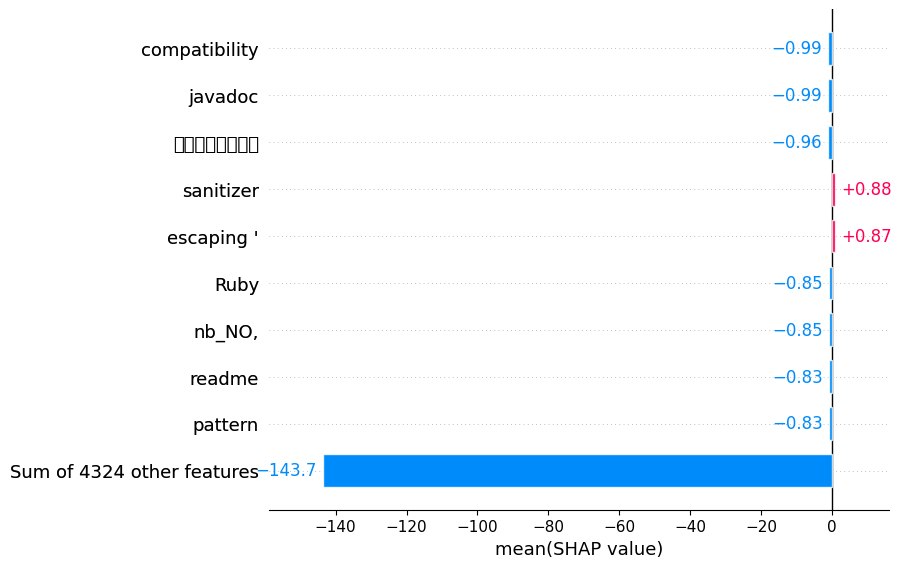

In [208]:
shap_values = explainer(fine_messages)
shap.plots.bar(shap_values[:,:,0].mean(0), show=False, max_display=10) #  order=shap.Explanation.argsort.flip)

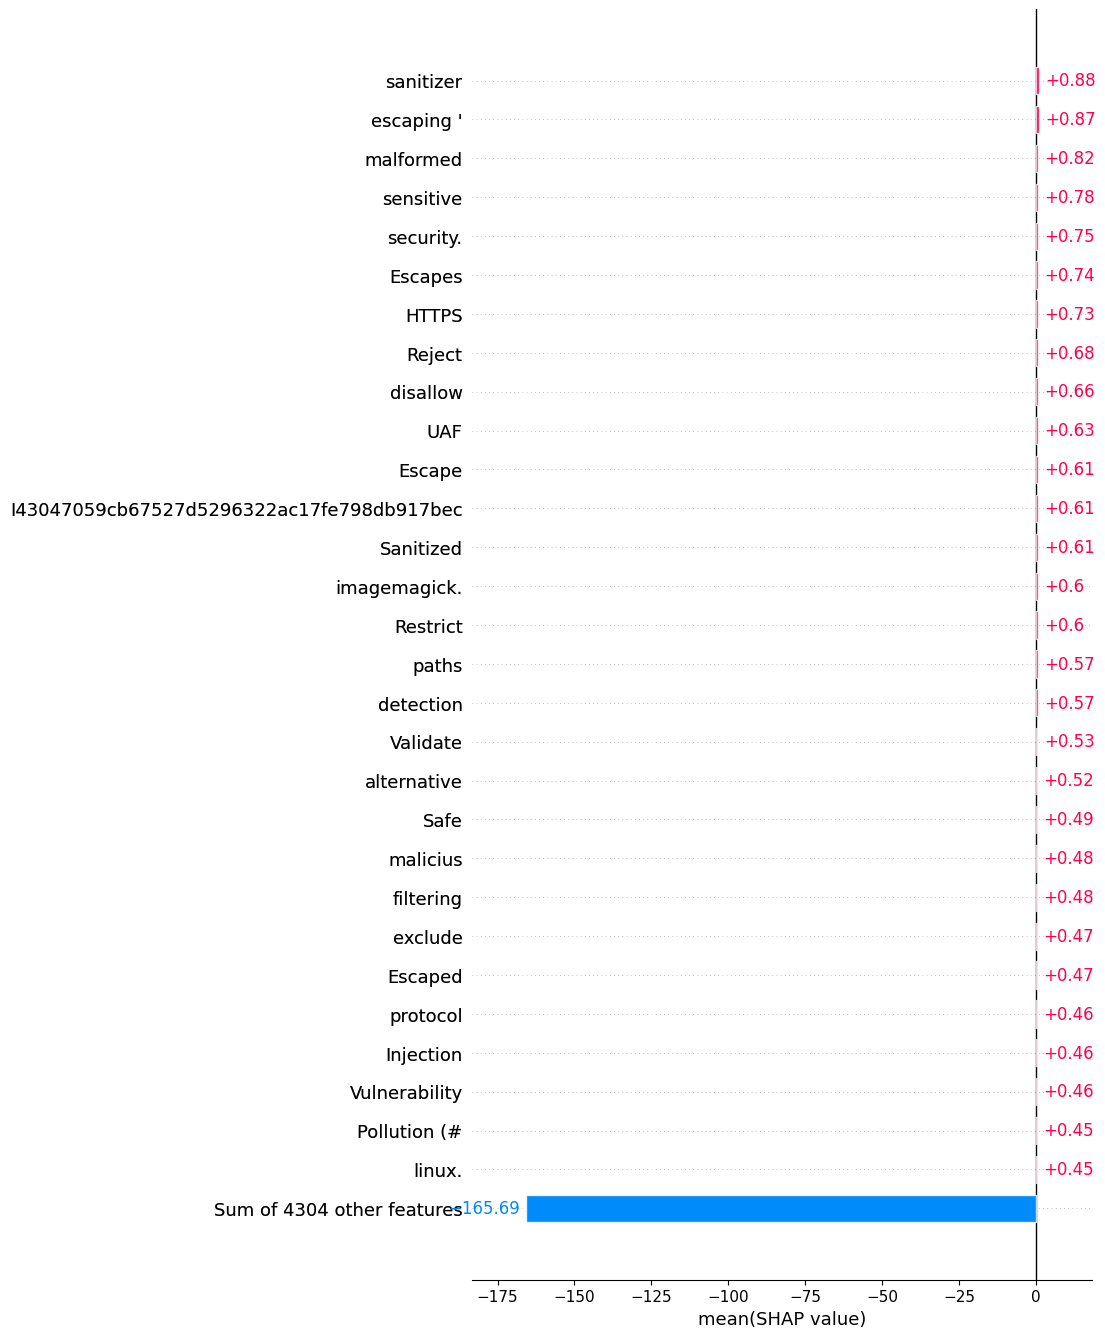

In [223]:
shap.plots.bar(shap_values[:,:,0].mean(0), show=False, max_display=30 , order=shap.Explanation.argsort.flip)

In [220]:
shap_values[:,:,0].mean(0)

(616, None, 2)

In [109]:
# 3
# Todo understand which label is which
shap.plots.bar(res, show=False, max_display=20,  order=shap.Explanation.argsort.flip)

plt.title("Impactful words for label security patch")
run.log({"Label 0":wandb.Image(plt)})
plt.show()


NameError: name 'res' is not defined

In [ ]:


shap.plots.bar(shap_values[:,:,1].mean(0), show=False, max_display=20,  order=shap.Explanation.argsort.flip)
plt.title("Impactful words for non-security patch")
run.log({"Label 1":wandb.Image(plt)})
plt.show()


In [6]:
security_words = {
    "Sanitizer":0.88,
    "Escaping":0.87,
    "Malformed":0.82,
    "Sensitive":0.78,
    "Security":0.75,
    "Escapes":0.74,
    "HTTPS":0.73,
    "Reject":0.68,
    "disallow":0.66,
    "UAF":0.61,
    "Escape":0.61,
    "Sanitized":0.61,
    "Restricted":0.6,
    "Paths":0.57,
    "Detection":0.57,
    "validate": 0.53,
    "Alternative":0.52,
    "Safe":0.49,
    "Malicious":0.48,
    "Filtering":0.48,
}



from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 3200, height = 3200,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate_from_frequencies(security_words)
# plot the WordCloud image    
from matplotlib import pyplot as plt                  
plt.figure(figsize = (100, 100), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


In [36]:
f_names =  ['Add', 'Del', 'Files', 'PullRequestEvent', 'PushEvent',
       'ReleaseEvent', 'DeleteEvent', 'issues', 'CreateEvent', 'releases',
       'IssuesEvent', 'ForkEvent', 'WatchEvent',
       'PullRequestReviewCommentEvent', 'stargazers', 'pullRequests',
       'commits', 'CommitCommentEvent', 'MemberEvent', 'GollumEvent',
       'IssueCommentEvent', 'forks', 'PullRequestReviewEvent',
       'PublicEvent', 'owner_isVerified', 'owner_isHireable',
       'owner_isGitHubStar', 'owner_isCampusExpert',
       'owner_isDeveloperProgramMember', 'owner_isSponsoringViewer',
       'owner_isSiteAdmin', 'isInOrganization', 'hasIssuesEnabled',
       'hasWikiEnabled', 'isMirror', 'isSecurityPolicyEnabled',
       'diskUsage', 'owner_isEmployee', 'year_2000', 'year_2001',
       'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022', 'repo_creation_data_2015', 'fundingLinks',
       '1C Enterprise', 'AGS Script', 'AIDL', 'AMPL', 'ANTLR',
       'API Blueprint', 'ASL', 'ASP', 'ASP.NET', 'ActionScript', 'Ada',
       'Agda', 'Alloy', 'AngelScript', 'ApacheConf', 'Apex',
       'AppleScript', 'Arc', 'AspectJ', 'Assembly', 'Asymptote', 'Augeas',
       'AutoHotkey', 'AutoIt', 'Awk', 'BASIC', 'Ballerina', 'Batchfile',
       'Berry', 'Bicep', 'Bikeshed', 'BitBake', 'Blade', 'BlitzBasic',
       'Boogie', 'Brainfuck', 'Brightscript', 'C', 'C#', 'C++', 'CMake',
       'COBOL', 'CSS', 'CUE', 'CWeb', 'Cadence', "Cap'n Proto", 'Ceylon',
       'Chapel', 'Charity', 'ChucK', 'Clarion', 'Classic ASP', 'Clean',
       'Clojure', 'Closure Templates', 'CodeQL', 'CoffeeScript',
       'ColdFusion', 'Common Lisp', 'Common Workflow Language', 'Coq',
       'Cuda', 'Cython', 'D', 'DIGITAL Command Language', 'DM', 'DTrace',
       'Dart', 'Dhall', 'Dockerfile', 'Dylan', 'E', 'ECL', 'EJS',
       'Eiffel', 'Elixir', 'Elm', 'Emacs Lisp', 'EmberScript', 'Erlang',
       'Euphoria', 'F#', 'F*', 'FLUX', 'Fancy', 'Faust', 'Filebench WML',
       'Fluent', 'Forth', 'Fortran', 'FreeBasic', 'FreeMarker', 'GAP',
       'GCC Machine Description', 'GDB', 'GDScript', 'GLSL', 'GSC',
       'Game Maker Language', 'Genshi', 'Gherkin', 'Gnuplot', 'Go',
       'Golo', 'Gosu', 'Groff', 'Groovy', 'HCL', 'HLSL', 'HTML', 'Hack',
       'Haml', 'Handlebars', 'Haskell', 'Haxe', 'Hy', 'IDL', 'IGOR Pro',
       'Inform 7', 'Inno Setup', 'Ioke', 'Isabelle', 'Jasmin', 'Java',
       'JavaScript', 'JetBrains MPS', 'Jinja', 'Jolie', 'Jsonnet',
       'Julia', 'Jupyter Notebook', 'KRL', 'Kotlin', 'LLVM', 'LSL',
       'Lasso', 'Latte', 'Less', 'Lex', 'Limbo', 'Liquid', 'LiveScript',
       'Logos', 'Lua', 'M', 'M4', 'MATLAB', 'MAXScript', 'MLIR', 'MQL4',
       'MQL5', 'Macaulay2', 'Makefile', 'Mako', 'Mathematica', 'Max',
       'Mercury', 'Meson', 'Metal', 'Modelica', 'Modula-2', 'Modula-3',
       'Module Management System', 'Monkey', 'Moocode', 'MoonScript',
       'Motoko', 'Mustache', 'NASL', 'NSIS', 'NewLisp', 'Nextflow',
       'Nginx', 'Nim', 'Nit', 'Nix', 'Nu', 'OCaml', 'Objective-C',
       'Objective-C++', 'Objective-J', 'Open Policy Agent',
       'OpenEdge ABL', 'PEG.js', 'PHP', 'PLSQL', 'PLpgSQL', 'POV-Ray SDL',
       'Pan', 'Papyrus', 'Pascal', 'Pawn', 'Perl', 'Perl 6', 'Pike',
       'Pony', 'PostScript', 'PowerShell', 'Processing', 'Procfile',
       'Prolog', 'Promela', 'Pug', 'Puppet', 'PureBasic', 'PureScript',
       'Python', 'QML', 'QMake', 'R', 'RAML', 'REXX', 'RPC', 'RPGLE',
       'RUNOFF', 'Racket', 'Ragel', 'Ragel in Ruby Host', 'Raku',
       'ReScript', 'Reason', 'Rebol', 'Red', 'Redcode', 'RenderScript',
       'Rich Text Format', 'Riot', 'RobotFramework', 'Roff',
       'RouterOS Script', 'Ruby', 'Rust', 'SAS', 'SCSS', 'SMT', 'SQLPL',
       'SRecode Template', 'SWIG', 'Sage', 'SaltStack', 'Sass', 'Scala',
       'Scheme', 'Scilab', 'Shell', 'ShellSession', 'Sieve', 'Slice',
       'Slim', 'SmPL', 'Smali', 'Smalltalk', 'Smarty', 'Solidity',
       'SourcePawn', 'Stan', 'Standard ML', 'Starlark', 'Stata',
       'StringTemplate', 'Stylus', 'SuperCollider', 'Svelte', 'Swift',
       'SystemVerilog', 'TLA', 'TSQL', 'Tcl', 'TeX', 'Tea', 'Terra',
       'Thrift', 'Turing', 'Twig', 'TypeScript', 'UnrealScript', 'VBA',
       'VBScript', 'VCL', 'VHDL', 'Vala', 'Velocity Template Language',
       'Verilog', 'Vim Snippet', 'Vim script', 'Visual Basic',
       'Visual Basic .NET', 'Volt', 'Vue', 'WebAssembly', 'Wren', 'X10',
       'XProc', 'XQuery', 'XS', 'XSLT', 'Xtend', 'YARA', 'Yacc', 'Yul',
       'Zeek', 'Zig', 'eC', 'jq', 'kvlang', 'mupad', 'nesC', 'q', 'sed',
       'xBase', 'timezone_-12', 'timezone_-11', 'timezone_-10',
       'timezone_-9', 'timezone_-8', 'timezone_-7', 'timezone_-6',
       'timezone_-5', 'timezone_-4', 'timezone_-3', 'timezone_-2',
       'timezone_-1', 'timezone_0', 'timezone_1', 'timezone_2',
       'timezone_3', 'timezone_4', 'timezone_5', 'timezone_6',
       'timezone_7', 'timezone_8', 'timezone_9', 'timezone_10',
       'timezone_11', 'timezone_12', 'timezone_13', 'timezone_14']

import pickle
with open('time_shap.pickle','rb') as mfile:
    shap_values = pickle.loads(mfile.read())





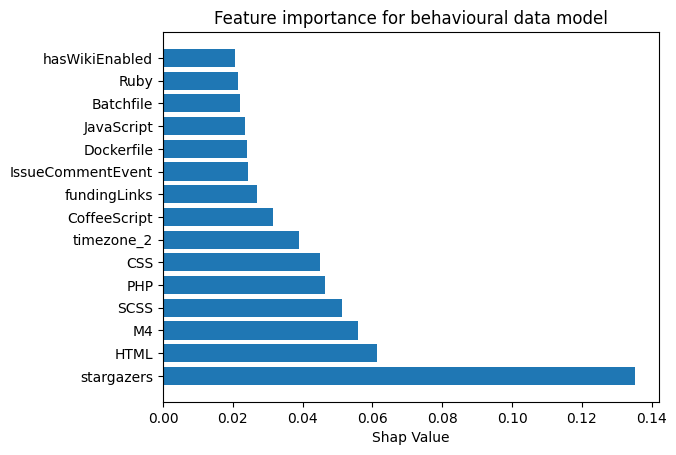

In [39]:
import matplotlib 

shap_values_per_column = sorted([(f_names[i],sum_0[0][i]) for i, _ in enumerate(f_names)], key=lambda x: x[1], reverse=True)[:15]
people = list(zip(*shap_values_per_column))[0]
score = list(zip(*shap_values_per_column))[1]
x_pos = np.arange(len(people)) 


plt.barh(x_pos, score,align='center')
plt.yticks(x_pos, people) 
fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(10, 10.5)
matplotlib.rc('ytick', labelsize=15) 

# plt.ylabel('Feature')
plt.xlabel('Shap Value')
plt.title('Feature importance for behavioural data model')
plt.savefig(r"C:\Users\nitzan\Pictures\FeatureImportanceForTimeModel.png", dpi=1000, bbox_inches='tight')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (401,) and arg 3 with shape (401, 2).

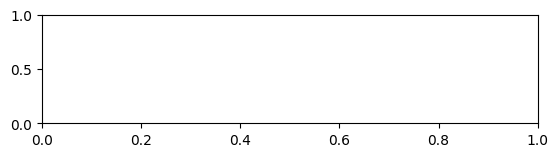

In [38]:
from matplotlib import pyplot as plt
import numpy as np
shap_val = np.array(shap_values)
shap_val = np.reshape(shap_val,(-1,int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
x_pos = [(i,sum_0[1][i]) for i, _ in enumerate(f_names)]
plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Yesterdays features (time-step 2)")
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("The day before yesterdays features(time-step 1)")
plt.tight_layout()
plt.show()

In [ ]:
[('stargazers', 0.08746620005877048),
 ('HTML', 0.058625271199161944),
 ('issues', 0.05697294613401027),
 ('M4', 0.04719718598357758),
 ('SCSS', 0.04386861348939419),
 ('CSS', 0.043140560686879326),
 ('PHP', 0.033720925054012696),
 ('IssueCommentEvent', 0.028475223752820966),
 ('CoffeeScript', 0.02755848198626154),
 ('timezone_2', 0.02752556661835115),
 ('WatchEvent', 0.026611074354150333),
 ('forks', 0.02596767228646968),
 ('fundingLinks', 0.02495312240716885),
 ('hasWikiEnabled', 0.023622608173809567),
 ('Dockerfile', 0.020990617071220186),
 ('Batchfile', 0.019817057797581583),
 ('Ruby', 0.01927653640950666),
 ('Del', 0.01882700375568902),
 ('JavaScript', 0.018598913021378394),
 ('Roff', 0.01751438355404389),
 ('isInOrganization', 0.017478053627542067),
 ('NSIS', 0.016701317599938648),
 ('Shell', 0.015114640231104204),
 ('Files', 0.015011608820032052),

In [39]:
f_names

['Add',
 'Del',
 'Files',
 'PullRequestEvent',
 'PushEvent',
 'ReleaseEvent',
 'DeleteEvent',
 'issues',
 'CreateEvent',
 'releases',
 'IssuesEvent',
 'ForkEvent',
 'WatchEvent',
 'PullRequestReviewCommentEvent',
 'stargazers',
 'pullRequests',
 'commits',
 'CommitCommentEvent',
 'MemberEvent',
 'GollumEvent',
 'IssueCommentEvent',
 'forks',
 'PullRequestReviewEvent',
 'PublicEvent',
 'owner_isVerified',
 'owner_isHireable',
 'owner_isGitHubStar',
 'owner_isCampusExpert',
 'owner_isDeveloperProgramMember',
 'owner_isSponsoringViewer',
 'owner_isSiteAdmin',
 'isInOrganization',
 'hasIssuesEnabled',
 'hasWikiEnabled',
 'isMirror',
 'isSecurityPolicyEnabled',
 'diskUsage',
 'owner_isEmployee',
 'year_2000',
 'year_2001',
 'year_2002',
 'year_2003',
 'year_2004',
 'year_2005',
 'year_2006',
 'year_2007',
 'year_2008',
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
 'year_2019',
 'year_2020',
 'year

In [12]:
from datasets import TextDataset
args.message_embedding_type = 'commit_message' 
args.commit_repos_path = '.'
message_tokenizer = get_tokenizer(
    args, args.message_model_type, args.message_tokenizer_name)
dataset = TextDataset(message_tokenizer, args, mall,
                        mall.keys(), args.message_embedding_type)

07/14/2023 15:41:39 - WARNING - datasets -   Loading dataset
07/14/2023 15:41:39 - WARNING - datasets -   Get Commits from cache
07/14/2023 15:42:01 - WARNING - datasets -   Number of commits: 27129
07/14/2023 15:42:01 - WARNING - datasets -   Get final list from cache


In [31]:
a = dataset.commit_list[:5000]

'09014418391cab8b11427d19d8c968b594f56925'

In [34]:
from lingua import Language, LanguageDetectorBuilder
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()
for cmt in a:
    det = detector.detect_language_of(cmt['message'])
    if det and det.name and det.name != 'ENGLISH':
        print(det)
        print(cmt['hash'])
        print(cmt['message'])
        print("")


Language.TSONGA
0010d28de1b15d51db3976080e26357fa7144436
Fix #5

Language.CATALAN
001c539cfcf945b47c9cd5728eeca24f014ce96b
minor refactor

- no dependencies
- uses es2015

Language.TSONGA
0031d65156a99d3c874779026d0132b93c6608df
fixup

Language.LATIN
00595351400523168e18a08e3ffa5c3b1e7c1f6e
fix potential XSS

Language.LATIN
005c022f638c24d837a2760b08b4047dec0bdbee
Minor code cleanup for pdc

Language.NYNORSK
005c262fda0358aad2764c726ff225710ff03b97
Update README.md

Language.XHOSA
005dc8e9eccc6ea35264064ae09e2e84af8d5b59
Fix database field from 1.11.x

https://github.com/chamilo/chamilo-lms/commit/f7f93579ed64765c2667910b9c24d031b0a00571

Language.ITALIAN
0062ce6b01696422d885f5826cbbc368c6640cc4
Merge branch 'QA_5_2'

Signed-off-by: Maurício Meneghini Fauth <mauricio@fauth.dev>

Language.SWEDISH
00706a5ad4fc90bd84ce36dbff627c25777c90ee
css

Language.FRENCH
008685aa9c7276da318b4cb07547517ff8f0e4fc
observers: autocrypt

Language.GERMAN
00a1b160f873ad2eb5fff7e1cbf84bf593bab37f
fix prettie

In [49]:
(269+30.0) / (41+488)

0.5652173913043478

In [74]:
df

,Name,Hash,Prediction,Actual
0,libgd_libgd,2bb97f407c1145c850416a3bfbcc8cf124e68a19,True,1
1,neomutt_neomutt,6296f7153f0c9d5e5cd3aaf08f9731e56621bdd3,True,1
2,neomutt_neomutt,fa1db5785e5cfd9d3cd27b7571b9fe268d2ec2dc,True,1
3,pimcore_pimcore,35d1853baf64d6a1d90fd8803e52439da53a3911,True,1
4,pimcore_pimcore,e786fd44aac46febdbf916ed6c328fbe645d80bf,True,1
...,...,...,...,...
823,zmartzone_mod_auth_openidc,ca8ea28f594592939afa08b44494ea0fd9f4382a,False,0
824,zmartzone_mod_auth_openidc,a9a85193722e9a46a216a160092ffecb876a82d7,False,0
825,zmartzone_mod_auth_openidc,78b4a1806704bf53f4c905b76294118ec2d1129c,True,0
826,krb5_krb5,c5b0a998d6349f8c90821a347db5666aed0e50eb,False,0


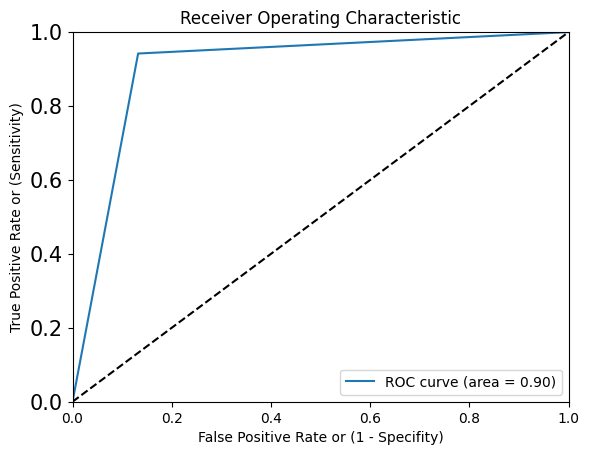

In [69]:
# !pip install seaborn
# import seaborn as sn

final_table = r"C:\Users\nitzan\Downloads\wandb_export_2023-07-15T08_32_35.436+03_00.csv"
df = pd.read_csv(final_table)

# create roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(df['Actual'], df['Prediction'])
roc_auc = auc(fpr, tpr)

# draw with pyplot
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])    
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()





In [ ]:

# # create confusion table with sklearn
# from sklearn.metrics import confusion_matrix
# conf = confusion_matrix(df['Actual'], df['Prediction'])
tn=400
fp=41
fn=30
tp=488

print(f"{tn=}, {fp=}, {fn=}, {tp=}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")
print(f"Precision = {tp/(tp+fp)}")
print(f"Recall = {tp/(tp+fn)}")
print(f"F1 = {2*tp/(2*tp+fp+fn)}")

print("\n Recalculating after removing 19 false positives")
tp+=19
fp-=19
print(f"{tn=}, {fp=}, {fn=}, {tp=}")
print(f"Accuracy = {(tp+tn)/(tp+tn+fp+fn)}")
print(f"Precision = {tp/(tp+fp)}")
print(f"Recall = {tp/(tp+fn)}")
print(f"F1 = {2*tp/(2*tp+fp+fn)}")


# plt.figure(figsize = (10,7))
# sn.heatmap(conf, annot=True)